In [2]:
import pandas as pd
import geopandas as gpd

/Users/shelbyjouppi/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Import Data

I want two geojson files with agregates of Medicaid enrollment data:
  
- Zip Code Level
- UHF Code level

Data Sources:
- Zip Code Shapfile: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
- UHF Code GeoJSON:
- Medicaid Enrollment Data: NYS Department of Health FOIL June 2022

#### Medicaid enrollment age 5-18 by zip code for 2022


In [10]:
medicaid22 = pd.read_excel('data/FFS  MC Enrollment Count by Zip - Members Aged 5 to 18 - January 2017 thru June 2022.xlsx',sheet_name='FFS&MC Enrollment 2017-2022',dtype={"Residence Zip5":str},header=3)
medicaid22.columns = medicaid22.columns.str.lower().str.replace(' ',"_")
display(medicaid22.head(5))
display(medicaid22.shape)

,residence_zip5,mc_ffs,2017_mbr_cnt,2018_mbr_cnt,2019_mbr_cnt,2020_mbr_cnt,2021_mbr_cnt,2022_mbr_cnt
0,00000,FFS,NaN,NaN,NaN,NaN,NaN,NaN
1,00000,MANAGED CARE,NaN,NaN,NaN,NaN,NaN,NaN
2,00003,MANAGED CARE,NaN,NaN,NaN,NaN,NaN,NaN
3,00063,MANAGED CARE,NaN,NaN,NaN,NaN,NaN,NaN
4,00192,MANAGED CARE,NaN,NaN,NaN,NaN,NaN,NaN


(10417, 8)

#### NYC Zip code shapefile

In [11]:
nycZips = gpd.read_file('data/ZIP_CODE_040114.zip')
display(nycZips.head(1))
display(nycZips.shape)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."


(263, 13)

In [19]:
# WHY ARE THEIR DUPLICATE ENTRIES?
nycZips.ZIPCODE.nunique()

248

In [20]:
nycZips.ZIPCODE.value_counts()

10004    4
11693    4
10464    3
11231    2
10047    2
        ..
10002    1
11378    1
10009    1
10012    1
10119    1
Name: ZIPCODE, Length: 248, dtype: int64

<AxesSubplot:>

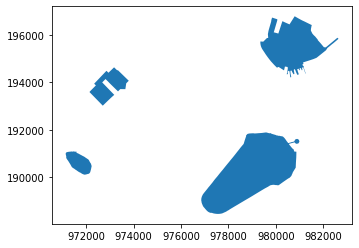

In [23]:
nycZips.query('ZIPCODE == "10004"').plot()
# I guess these zip codes cover many disconnected pieces of land

#### UHF Codes

In [13]:
# Neighborhood Codes by Zip Code
uhfCodes = pd.read_csv('data/uhf-codes-nyc-clean.csv',dtype={"zipcode":str,"uhf_code":str} )
display(uhfCodes.head(3))
display(uhfCodes.shape)

# Neighborhood Codes Shapefile
uhfCodesGeo = gpd.read_file('data/uhfcodes.geojson')
uhfCodesGeo['UHFCODE'] = uhfCodesGeo['UHFCODE'].astype('str').str.split(".").str[0]
display(uhfCodesGeo.head(3))
display(uhfCodesGeo.shape)

,uhf_code,neighborhood,zipcode
0,101,Kingsbridge - Riverdale,10463
1,102,Northeast Bronx,10466
2,103,Fordham - Bronx Park,10458


(176, 3)

,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,UHF_NEIGH,BOROUGH,geometry
0,1,0,207587.595627,2.764099e+08,None,N/A,"MULTIPOLYGON (((1052698.331 161778.389, 105230..."
1,2,101,57699.154353,1.332914e+08,Kingsbridge - Riverdale,Bronx,"MULTIPOLYGON (((1017992.893 269222.964, 101781..."
2,3,102,88219.319109,1.813708e+08,Northeast Bronx,Bronx,"MULTIPOLYGON (((1025012.990 270794.260, 102506..."


(43, 7)

## Merging Medicaid Data For NYC
### First let's go by Zip Code

In [14]:
# Saving a new dataframe filtering zip codes to NYC zip codes
nycMedicaid = medicaid22.query('residence_zip5.isin(@nycZips.ZIPCODE)')
display(nycMedicaid.head())
display(nycMedicaid.shape)

,residence_zip5,mc_ffs,2017_mbr_cnt,2018_mbr_cnt,2019_mbr_cnt,2020_mbr_cnt,2021_mbr_cnt,2022_mbr_cnt
913,10001,FFS,118.0,121.0,140.0,102.0,57.0,74.0
914,10001,MANAGED CARE,853.0,1045.0,1053.0,990.0,948.0,864.0
915,10002,FFS,375.0,346.0,345.0,287.0,208.0,277.0
916,10002,MANAGED CARE,7727.0,7319.0,6872.0,6549.0,6446.0,6027.0
917,10003,FFS,36.0,44.0,43.0,44.0,47.0,40.0


(431, 8)

In [15]:
# There are 240 zips here, but 263 in original file. Which are missing?
nycMedicaid.residence_zip5.nunique()

240

In [17]:
# THESE ZIP CODES HAVE ZERO PEOPLE IN THEM, EXCEPT FOR CENTRAL PARK WHICH THE MEDICAID DATA WOULD BE TOO
# TOO SMALL TO INCLUDE.
nycZips.query('~ZIPCODE.isin(@nycMedicaid.residence_zip5)')

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
50,10048,0,New York,0.0,9.727884e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981026.765 197865.690, 981013.562 19..."
54,00083,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.725 229616.681, 998282.853 22..."
239,10097,1,New York,0.0,6.582618e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((988345.340 217131.826, 988452.711 21..."
240,10196,1,New York,0.0,3.250244e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989117.631 214999.878, 989200.981 21..."
241,10196,1,New York,0.0,3.154825e+03,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989421.941 214975.278, 989408.779 21..."
242,10275,1,New York,0.0,4.828042e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((980227.090 196328.461, 980298.506 19..."
249,10259,1,New York,0.0,2.106431e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981377.148 197499.868, 981411.167 19..."
251,10285,1,New York,0.0,6.735039e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((980157.859 199073.522, 980081.819 19..."
252,10286,1,New York,0.0,1.126441e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981654.605 196643.665, 981725.103 19..."


##### How many children are insured by MC vs FFS?

In [24]:
nycMedicaid.groupby('mc_ffs')['2022_mbr_cnt'].sum()

mc_ffs
FFS              47439.0
MANAGED CARE    835677.0
Name: 2022_mbr_cnt, dtype: float64

In [25]:
# What percent is that?
47439/835677

0.05676714807276017

##### How many children are enrolled in Medicaid?
(minus the children who were in zip codes too small to count for privacy concerns)

In [27]:
nycZipTotals['AGE_5-18'].sum()

883116.0

### Summing FFS & MC enrollment for each zip code.

In [26]:
nycZipTotals = nycMedicaid.groupby('residence_zip5')['2022_mbr_cnt'].sum().reset_index().copy(deep=True).rename({'residence_zip5':'ZIPCODE','2022_mbr_cnt':'AGE_5-18'},axis=1)
display(nycZipTotals.shape)
nycZipTotals.head()

(240, 2)

,ZIPCODE,AGE_5-18
0,10001,938.0
1,10002,6304.0
2,10003,339.0
3,10004,108.0
4,10005,50.0


In [32]:
# Merging Zip Enrollment Totals and Zip Shape File
nycZipMergeGeo = nycZips.merge(nycZipTotals,how='left',left_on='ZIPCODE',right_on='ZIPCODE')
display(nycZipMergeGeo.head())
nycZipMergeGeo.shape

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,AGE_5-18
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",2032.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",7920.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",15065.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",5071.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",11265.0


(263, 14)

Good! I have 263 records -- one for every original zip code shape file. That means my aggregate data will be shared across all the shapes for the zip codes with multiple polygons

### Exporting to GeoJSON

In [33]:
# Saving it as a geodataframe
nycZipMergeGeo = gpd.GeoDataFrame(
    nycZipMergeGeo, geometry='geometry'
 )

# Exporting it
nycZipMergeGeo.to_file('data/nycEnrollmentZip.geojson',driver='GeoJSON')

nycZipMergeGeo.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Now let's get enrollment by UHF Codes

In [36]:
# Merging Neighborhood Codes with the nycZipMergeGeo
zipUHF = nycZipMergeGeo.merge(uhfCodes, how='left',left_on='ZIPCODE',right_on='zipcode')

# Creating enrollment totals for neighborhoods and merging with code shapefile 
UHF_totals = zipUHF.groupby('uhf_code')['AGE_5-18'].sum().to_frame().reset_index()
nycMergeUHFGeo = UHF_totals.merge(uhfCodesGeo,how='left',left_on='uhf_code',right_on='UHFCODE')

nycMergeUHFGeo.head()

,uhf_code,AGE_5-18,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,UHF_NEIGH,BOROUGH,geometry
0,101,13016.0,2,101,57699.154353,1.332914e+08,Kingsbridge - Riverdale,Bronx,"MULTIPOLYGON (((1017992.893 269222.964, 101781..."
1,102,20866.0,3,102,88219.319109,1.813708e+08,Northeast Bronx,Bronx,"MULTIPOLYGON (((1025012.990 270794.260, 102506..."
2,103,43358.0,4,103,59711.871991,1.407724e+08,Fordham - Bronx Park,Bronx,"MULTIPOLYGON (((1023994.480 261065.967, 102388..."
3,104,41448.0,5,104,250903.372273,3.865737e+08,Pelham - Throgs Neck,Bronx,"MULTIPOLYGON (((1017075.039 237316.182, 101707..."
4,105,43293.0,6,105,66676.089072,1.068978e+08,Crotona - Tremont,Bronx,"MULTIPOLYGON (((1007916.255 252530.752, 100823..."


### Exporting to GeoJSON

In [37]:
# Saving it as a geodataframe
nycMergeUHFGeo = gpd.GeoDataFrame(
    nycMergeUHFGeo, geometry='geometry'
 )

# Exporting it
nycMergeUHFGeo.to_file('data/nycEnrollmentUHF.geojson',driver='GeoJSON')

# Let's assign it a CRS for Altair
nycMergeUHFGeo.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich